In [2]:
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

c:\Miniconda\envs\audio_recognition\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\Miniconda\envs\audio_recognition\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
def extract_features(file_path, n_mfcc=10, hop_length=327, win_length=624):
   signal, sr = librosa.load(file_path)
   mfccs = librosa.feature.mfcc(y=signal,
                                 sr=sr,
                                 n_mfcc=n_mfcc,
                                 hop_length=hop_length,
                                 win_length=win_length)
   return mfccs

In [4]:
def load_data(directory):
   data = []
   labels = []
   for root, dirs, files in os.walk(directory):
      for file in files:
         if file.endswith(".wav"):
               file_path = os.path.join(root, file)
               label = os.path.basename(root)
               data.append(extract_features(file_path))
               labels.append(label)
   data = np.array(data)
   labels = np.array(labels)
   return data, labels

In [5]:
data, labels = load_data("data/augmented_data/test")

c:\Miniconda\envs\audio_recognition\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\Miniconda\envs\audio_recognition\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
data1, labels1 = load_data('data/augmented_data/train')

In [7]:
train_data = np.concatenate((data, data1))

In [8]:
train_label = np.concatenate((labels, labels1))

In [9]:
np.unique(train_label)

array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence',
       'stop', 'unknown', 'up', 'yes'], dtype='<U7')

In [10]:
for i, label in enumerate(labels):
   for j, text in enumerate(train_label):
      if text == label:
         train_label[j] = i

In [11]:
label_dict = {label: i for i, label in enumerate(np.unique(train_label))}
encoded_labels = np.array([label_dict[label] for label in train_label])
one_hot_labels = to_categorical(encoded_labels)

In [12]:
one_hot_labels.shape

(40206, 12)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_data, one_hot_labels, test_size=0.2, random_state=1, shuffle=True)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32164, 10, 49)
(8042, 10, 49)
(32164, 12)
(8042, 12)


c:\Miniconda\envs\audio_recognition\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


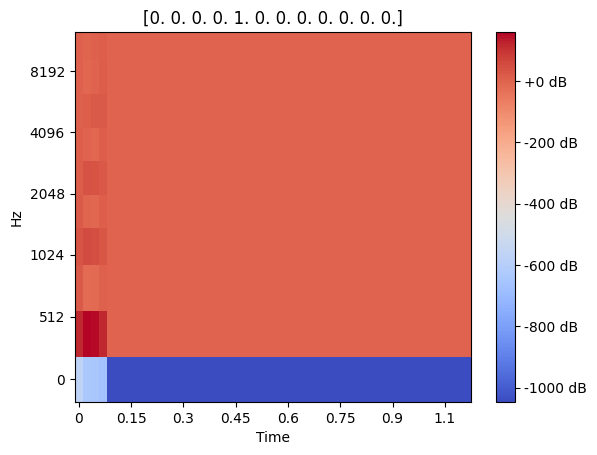

In [15]:
idx = 290
librosa.display.specshow(X_train[idx], x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(y_train[idx])
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

In [17]:
input_shape = X_train[0].shape

In [18]:
num_labels = 12

In [59]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    # layers.experimental.preprocessing.Resizing(32, 32),
    # Normalize.
    # norm_layer,
    layers.Conv1D(32, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 8, 32)             4736      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 32)             128       
_________________________________________________________________
activation (Activation)      (None, 8, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 64)             6208      
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 64)             256       
_________________________________________________________________
activation_1 (Activation)    (None, 6, 64)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4, 128)           

In [60]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [61]:
EPOCHS = 20
history = model.fit(
    X_train, y_train,
    batch_size = 64,
    validation_split=0.2,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=2, patience=4),
)

Epoch 1/20
403/403 [==============================] - 5s 10ms/step - loss: 2.3928 - accuracy: 0.2054 - val_loss: 1.9912 - val_accuracy: 0.3552
Epoch 2/20
403/403 [==============================] - 4s 10ms/step - loss: 1.8849 - accuracy: 0.3377 - val_loss: 1.6392 - val_accuracy: 0.4365
Epoch 3/20
403/403 [==============================] - 4s 11ms/step - loss: 1.6865 - accuracy: 0.4160 - val_loss: 1.4950 - val_accuracy: 0.4867
Epoch 4/20
403/403 [==============================] - 4s 9ms/step - loss: 1.5551 - accuracy: 0.4621 - val_loss: 1.4115 - val_accuracy: 0.5125
Epoch 5/20
403/403 [==============================] - 4s 9ms/step - loss: 1.5268 - accuracy: 0.4747 - val_loss: 1.3332 - val_accuracy: 0.5497
Epoch 6/20
403/403 [==============================] - 4s 9ms/step - loss: 1.4144 - accuracy: 0.5071 - val_loss: 1.2991 - val_accuracy: 0.5515
Epoch 7/20
403/403 [==============================] - 3s 8ms/step - loss: 1.3750 - accuracy: 0.5306 - val_loss: 1.2564 - val_accuracy: 0.5677
Epo

In [62]:
model.save('models/model.h5')

In [63]:
model = tf.keras.models.load_model('models/model.h5')

In [64]:
# Create a TensorFlow dataset from the numpy arrays
dataset = tf.data.Dataset.from_tensor_slices(X_test)

In [65]:
# Load the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [66]:
# Set the optimization flag to use default optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [67]:
# Provide a representative dataset
def representative_data_gen():
    for input_value in dataset.batch(1).take(100):
        yield [input_value]

In [68]:
converter.representative_dataset = representative_data_gen

In [69]:
# Set the supported operations to use int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [70]:
# Ensure the input and output tensors are also int8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [71]:
# Convert the model
tflite_quant_model = converter.convert()

KeyboardInterrupt: 

In [ ]:
# Save the TensorFlow Lite model
with open('models/model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

In [ ]:
tflite_model_path = 'models/model.tflite'

In [ ]:
# Get the size of the file in bytes
tflite_model_size_bytes = os.path.getsize(tflite_model_path)

In [ ]:
# Get the size of the file in bytes
tflite_model_size_bytes = os.path.getsize(tflite_model_path)

# Convert the size to a more readable format (e.g., kilobytes or megabytes)
tflite_model_size_kb = tflite_model_size_bytes / 1024  # Kilobytes
tflite_model_size_mb = tflite_model_size_bytes / (1024 * 1024)  # Megabytes

# Print the size
print(f"TensorFlow Lite model size: {tflite_model_size_bytes} bytes")
print(f"TensorFlow Lite model size: {tflite_model_size_kb:.2f} KB")
print(f"TensorFlow Lite model size: {tflite_model_size_mb:.2f} MB")

TensorFlow Lite model size: 95240 bytes
TensorFlow Lite model size: 93.01 KB
TensorFlow Lite model size: 0.09 MB


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("models/use_library_model.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("models/use_library_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\phamh\AppData\Local\Temp\tmpkckx6mut\assets


INFO:tensorflow:Assets written to: C:\Users\phamh\AppData\Local\Temp\tmpkckx6mut\assets


Model is 317656 bytes


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="models\model.tflite")
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Get the quantization parameters for the input
input_scale, input_zero_point = input_details[0]['quantization']

In [ ]:
# Placeholder for predictions
predictions = []

for i in range(len(X_test)):
   input_data = X_test[i:i+1]  # Get a single test sample

   # Quantize the input data from float32 to uint8
   input_data = (input_data / input_scale + input_zero_point).astype(np.uint8)

   # Set input tensor
   interpreter.set_tensor(input_details[0]['index'], input_data)

   # Run inference
   interpreter.invoke()

   # Get output tensor
   output_data = interpreter.get_tensor(output_details[0]['index'])
   predictions.append(output_data)

predictions = np.array(predictions).squeeze()

In [ ]:
predicted_labels = np.argmax(predictions, axis=1) if predictions.ndim > 1 else np.round(predictions)

In [ ]:
predicted_labels[0]

7

In [ ]:
y_true = np.argmax(y_test, axis=1)

In [ ]:
accuracy = accuracy_score(y_true, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 62.20%


In [ ]:
org_predict = model.predict(X_test)
org_pred = np.argmax(org_predict, axis=1)

In [ ]:
accuracy = accuracy_score(y_true, org_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 62.78%
